**Основные цели этого задания**:
*   попрактиковаться в анализе временных рядов,
*   научиться извлекать дополнительные признаки для прогнозирования временного ряда,
*   проверять качество модели на отложенной выборке.

**Задача: спрогнозировать число пассажиров авиакомпании помесячно**

In [86]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels import api as sm
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [60]:
pd.set_option('display.max_rows', None)

*1. Загрузите данные из источника по ссылке, ознакомьтесь с ними и подготовьте к аналитике*
*   Найдите и удалите пропуски, если они есть.
*   Поменяйте тип столбца с временными отсечками в datetime.
*   Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает.

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/W1llAnn/1tdata-homework/main/2.6AirPassengers.csv', delimiter=',')
df.head(5)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


**Пропусков в данных нет. Всего 144 строки и 2 колонки. Данные следующие - количество авиапассажиров в месяц (по месяцам)**

In [29]:
df.columns = df.columns.str.replace('#', '') # уберем знак, чтобы потом можно было обращаться к колонке через df.passengers

*Поменяйте тип столбца с временными отсечками в datetime*

In [30]:
df['Month'] = pd.to_datetime(df['Month'], format="%Y-%m")
df.head(5)

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


*Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает*

In [31]:
df.set_index('Month', inplace=True)

In [33]:
df.index.is_monotonic_increasing

True

**Данные преобразованы to_datetime, пропусков нет, продолжаем работать с ними**

*2. Проанализируйте временной ряд*
1.   Оставьте для аналитики лишь с 1952 по 1957 год (включительно).
2.   Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.
    *   Есть ли тренд?
    *   Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?
    *   Является ли ряд стационарным и почему?
3.   Постройте график, чтобы оценить автокорреляцию и сделайте выводы
    *   У какого сдвига самая высокая автокорреляция?
    *   Подтверждаются ли выводы о наличии тренда графиком автокорреляции?

In [37]:
df_52_57 = df['1952':'1957']
print(df_52_57.index.min(), df_52_57.index.max())

1952-01-01 00:00:00 1957-12-01 00:00:00


Если мы просто визуализируем данные, то получим следующее:

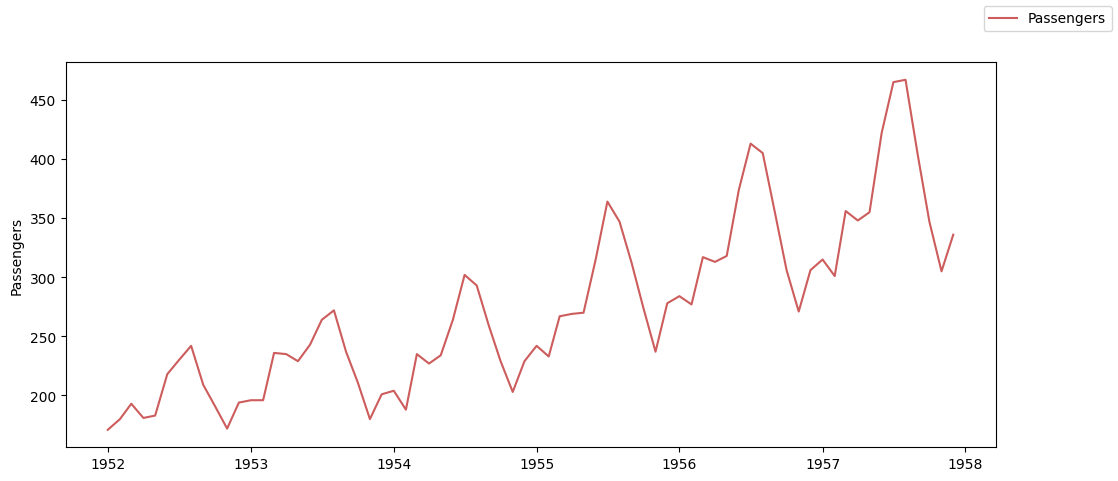

In [42]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])
ax.plot(df_52_57['Passengers'], c='indianred', label='Passengers')
ax.set_ylabel('Passengers')
fig.legend();

Просто посмотрев внешне, мы можем сказать что количесво пассажиров в какие-то месяца выше, а к какие-то ниже. *Но нам нужно понять тренды, сезонность и является ли ряд стационарным:*

In [44]:
decomposed = seasonal_decompose(df_52_57['Passengers']) 

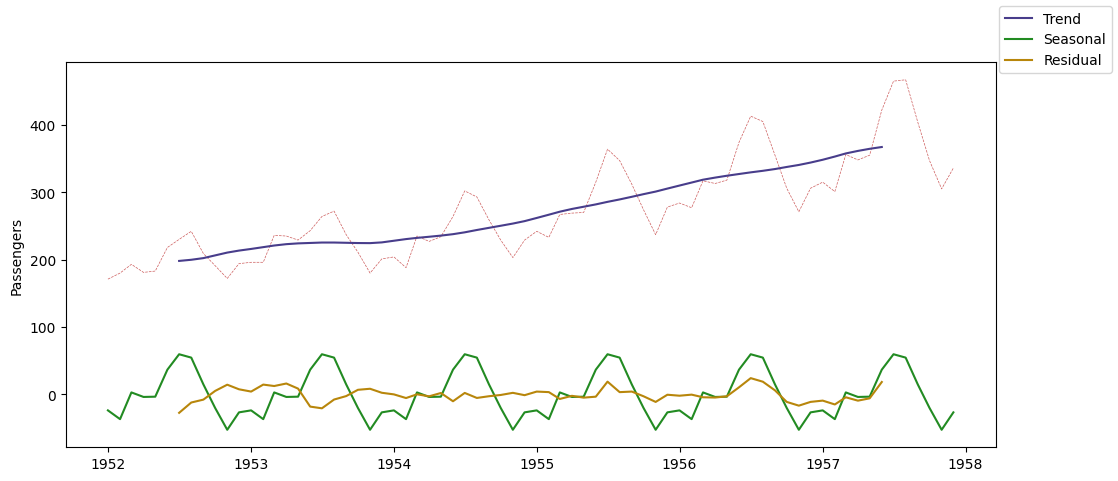

In [45]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(df_52_57['Passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('Passengers')

fig.legend();

In [62]:
print(decomposed.seasonal[:10])

Month
1952-01-01   -23.871528
1952-02-01   -36.904861
1952-03-01     2.795139
1952-04-01    -3.929861
1952-05-01    -3.538194
1952-06-01    36.570139
1952-07-01    59.470139
1952-08-01    54.461806
1952-09-01    14.695139
1952-10-01   -20.254861
Name: seasonal, dtype: float64


Что мы можем сказать, глядя на этот график:
*   Trend - Количество пассажиров растет от года к году
*   Seasonal - Наблюдается ежегодная сезонность, в том числе и при помощи decomposed.seasonal. Мы можем говорить о том, что в январе, феврале и декабре пассажиров меньше, чем в июне, июле и августе (например). Самая низкая сезонность в феврале, самая высокая в июле.

*Теперь посмотрим стационарность временного ряда:*

In [66]:
adf_test = adfuller(df_52_57['Passengers'])
 # выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.9925243723978878


**Значение p-value более 5% говорит нам о том, что можно отвергнуть нулевую гипотезу (Временной ряд стационарен) и мы можем говорить о нестационарности временного ряда**. Попробуем построить график дополнительно:

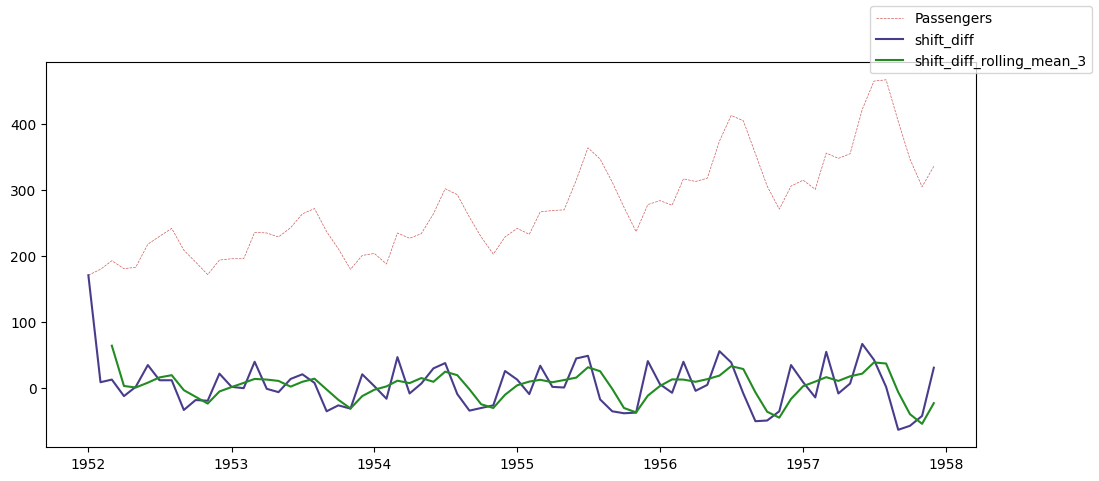

In [67]:
sales_diffs = df_52_57['Passengers'] - df_52_57['Passengers'].shift(fill_value=0)


fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(df_52_57['Passengers'], c='indianred', linewidth=0.5, linestyle='--', label='Passengers')
ax.plot(sales_diffs, c='darkslateblue', label='shift_diff')
ax.plot(sales_diffs.rolling(3).mean(), c='forestgreen', label='shift_diff_rolling_mean_3')

fig.legend();

**График также показывает, что временной ряд не стационарен. Исходя из выше сказанного мы делаем однозначный вывод: Временной ряд не стационарен**

*Теперь посмотрим автокорреляцию*

In [69]:
df_52_57['Passengers'].shape

acf = sm.tsa.acf(df_52_57['Passengers'])
acf.shape

(19,)

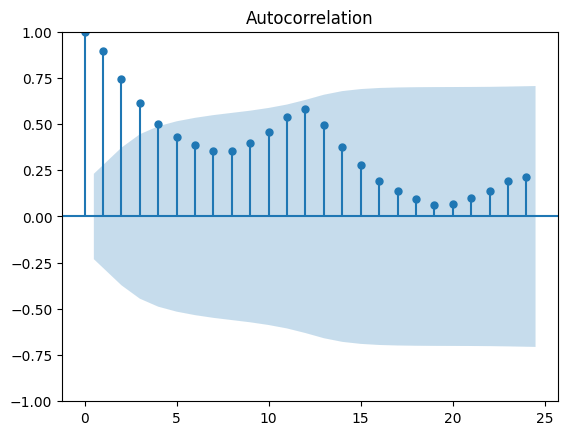

In [82]:
fig = tsaplots.plot_acf(df_52_57['Passengers'], lags=24)
plt.show() 

**На графике автокорреляции мы видим, что значения возрастают каждые 12 шагов, т.е. 0, 12, 24. А это подтверждает сезонность. Более того, мы видим что автокорреляция положительная, а это говорит о наличии тренда, что подтверждено нами ранее.**

**ОБЩИЙ ВЫВОД по п.2: в данных прослеживается тренд и сезонность, временной ряд не стационарен. Автокорреляция подтверждает тренд и сезонность.**

*3. Подготовьте данные к обучению линейной модели*
1.   Напишите функцию, которая будет генерировать новые признаки (календарные признаки, несколько колонок с разными сдвигами, несколько колонок с разными скользящими средними)
    *   Воспользуйтесь наработками из скринкастов.
    *   Добавьте аргумент, который будет отвечать за возможные сдвиги. Это должен быть список, по которому в цикле будет добавляться новая колонка lag_n, где n — число из этого списка, отвечающее за сдвиг.
    *   Добавьте аргумент, который будет отвечать за возможные размеры скользящего среднего. Это должен быть список, по которому в цикле будет добавляться новая колонка rolling_mean_m, где m — число из этого списка, отвечающее за размер окна, по которому вычисляется среднее. Не забудьте, что скользящее среднее нужно сдвигать, чтобы не было «заглядывания в будущее».
2.   Рассчитайте новые признаки с помощью реализованной функции, подав ей на вход произвольные параметры генерации новых признаков.
3.   Удалите наблюдения с пропусками в новых переменных.
4.   Разделите данные на признаки и целевую переменную.
5.   Разделите данные на обучающую и валидационную части. Не забудьте, что валидационная часть должна идти строго после обучающей.

In [105]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    
    for i in range(1, max_lag + 1):
        data[f'lag_{i}'] = data['Passengers'].shift(i)
        
    data['rolling_mean'] = data['Passengers'].rolling(rolling_mean_size).mean()
    data['rolling_mean'] = data['rolling_mean'].shift(1)
    
    return data

In [106]:
data_with_features = make_features(df_52_57[['Passengers']].copy(), 3, 3)
data_with_features.head()

,Passengers,year,month,quarter,lag_1,lag_2,lag_3,rolling_mean
Month,,,,,,,,
1952-01-01,171,1952,1,1,NaN,NaN,NaN,NaN
1952-02-01,180,1952,2,1,171.0,NaN,NaN,NaN
1952-03-01,193,1952,3,1,180.0,171.0,NaN,NaN
1952-04-01,181,1952,4,2,193.0,180.0,171.0,181.333333
1952-05-01,183,1952,5,2,181.0,193.0,180.0,184.666667


In [107]:
train, test = train_test_split(data_with_features.dropna(), shuffle=False, test_size=0.2)
train = train.dropna()

train_target = train['Passengers']
train_features = train.drop(['Passengers'], axis=1)
test_target = test['Passengers']
test_features = test.drop(['Passengers'], axis=1)

scaler = StandardScaler().fit(train_features)
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)

**Вывод: Добавили новые данные на основании предыдущих, убрали новые пропуски (новые данные NaN), разделили выборку на тестовую и обучающую.**

*4. Обучите линейную модель машинного обучения и оцените ее качество*
*   Обучите линейную модель на обучающей части данных.
*   Рассчитайте значение метрики качества MAE на обучающей и валидационных частях. Если модель работает плохо (метрика ниже 20), попробуйте выделить другой набор признаков, вызывая свою функцию с новыми параметрами.
*   Визуализируйте реальный временной ряд и прогнозные значения. 

In [101]:
model_l = LinearRegression()
model_l.fit(train_features_norm, train_target)

train_prediction = pd.Series(model_l.predict(train_features_norm))
train_prediction.index = train_features.index
test_prediction = pd.Series(model_l.predict(test_features_norm))
test_prediction.index = test_features.index

print("MAE обучающей выборки:" ,mean_absolute_error(train_target, train_prediction))
print("MAE тестовой выборки: " ,mean_absolute_error(test_target, test_prediction))

MAE обучающей выборки: 16.745898813355456
MAE тестовой выборки:  24.216010145357252


**MAE тестовой выборки более 20.**

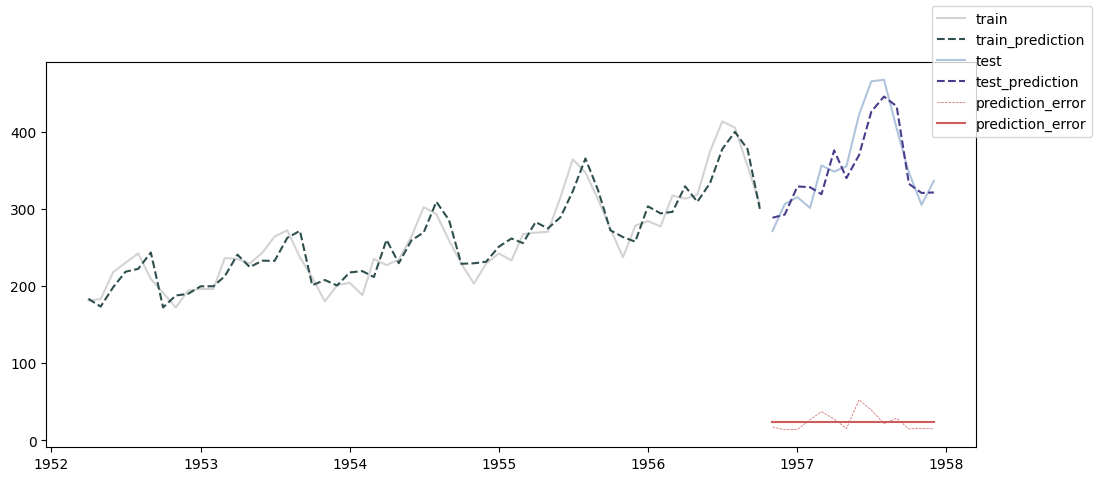

In [99]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['Passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();

**По графику мы видим, что модель в целом улавливает часть зависимостей.**

In [100]:
pd.DataFrame(zip(train_features.columns, abs(model_l.coef_)), columns=['feature', 'importance']).sort_values(by='importance', ascending=False)

,feature,importance
3,lag_1,68.694940
1,month,45.744065
4,lag_2,43.940354
2,quarter,38.390929
0,year,19.468238
6,rolling_mean,8.676754
5,lag_3,1.409315


**Самый большой вес имеет lag_1 (сдвиг на 1), затем month и lag_2 (сдвиг на 2) и после quarter, year, rolling_mean и lag_3.**

*5. Оцените качество модели на отложенной выборке. В качестве отложенной выборки у нас будут наблюдения с 1958 по 1960 год*
1.   Возьмите из источника необходимый срез данных.
2.   Подготовьте данные к прогнозированию.
    *   Добавьте признаки с помощью реализованной ранее функции.
    *   Удалите наблюдения с пропусками.
    *   Если после удаления у вас осталось менее 36 наблюдений, откорректируйте срез из пункта 5.а.
    *   Отделите целевую переменную от признаков.
3.   Постройте прогноз с помощью обученной ранее линейной модели.
4.   Рассчитайте значение метрики качества на отложенной выборке.
5.   Визуализируйте реальный временной ряд и прогнозные значения.

In [153]:
df_58_60 = df['1958':'1960']
print(df_58_60.index.min(), df_58_60.index.max())

1958-01-01 00:00:00 1960-12-01 00:00:00


In [154]:
df_58_60.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1958-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  36 non-null     int64
dtypes: int64(1)
memory usage: 576.0 bytes


In [155]:
df.iloc[-3:]

,Passengers
Month,
1960-10-01,461
1960-11-01,390
1960-12-01,432


**Пропустим условие в задании менее 36 признаков после удаления, так как в DataFrame все наблюдения заканчиваются на 1960 году, а другие данные мы уже использовали в нашей модели.**

In [156]:
data_with_features_2 = make_features(df_58_60[['Passengers']].copy(), 3, 3)
data_with_features_2 = data_with_features_2.dropna()

data_with_features_2.head()

,Passengers,year,month,quarter,lag_1,lag_2,lag_3,rolling_mean
Month,,,,,,,,
1958-04-01,348,1958,4,2,362.0,318.0,340.0,340.000000
1958-05-01,363,1958,5,2,348.0,362.0,318.0,342.666667
1958-06-01,435,1958,6,2,363.0,348.0,362.0,357.666667
1958-07-01,491,1958,7,3,435.0,363.0,348.0,382.000000
1958-08-01,505,1958,8,3,491.0,435.0,363.0,429.666667


In [157]:
test_target_2 = data_with_features_2['Passengers']
test_features_2 = data_with_features_2.drop(['Passengers'], axis=1)

test_features_norm_2 = scaler.transform(test_features_2)

In [162]:
test_prediction_2 = pd.Series(model_l.predict(test_features_norm_2))
test_prediction_2.index = test_features_2.index

print("MAE тестовой выборки: " ,mean_absolute_error(test_target_2, test_prediction_2))

MAE тестовой выборки:  34.99155053444826


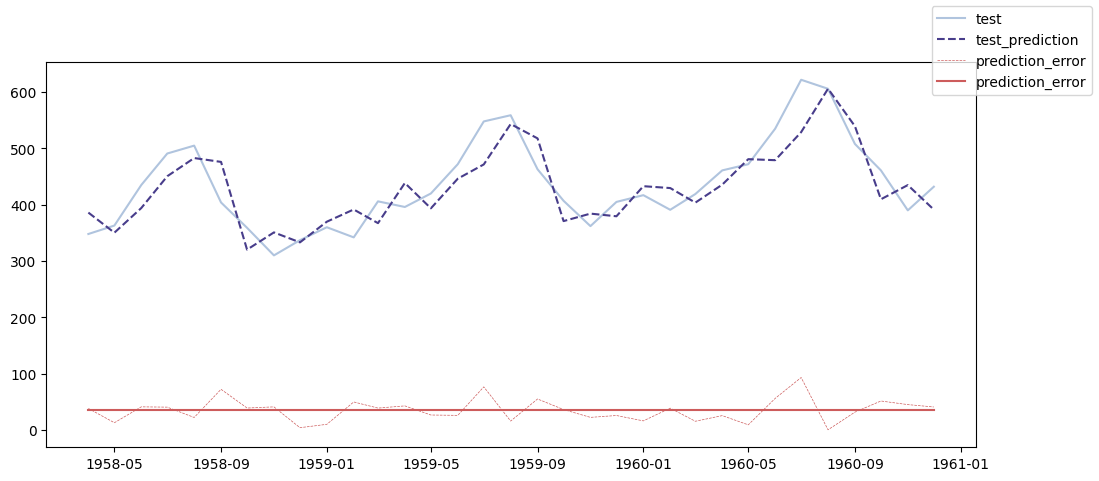

In [168]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test_target_2 - test_prediction_2)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test_target_2.index

ax.plot(test_target_2, c='lightsteelblue', label='test')
ax.plot(test_prediction_2, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();

**Вывод: Из графика мы видим, что модель уловила некоторые зависимости, но совершала ошибки в точности**

*6. Значение метрики MAE на отложенной выборке должно быть не менее 35.*

**Выводы: MAE тестовой выборки: 35**

*7. Выводы*

**Какую работу мы проделали**: 
*   Проверили данные на пропуски и преобразовали данные
*   Увидели в данных тренд и ежегодную сезонность
*   Добавили новые данные на основании предыдущих, обработали пропуски
*   Обучили модель линейной регрессии (LinearRegression)

**Теперь о модели**: В целом по графику мы увидели, что модель уловила некоторые зависимости, мы видим так же, что учтена сезонность и тренд. MAE в случае тестовой выборки и отложенной выборке были на уровне допустимого, исходя из условий задачи. Конечно, модель, или данные, на которых мы обучаем модель, нуждаются в доработке для более точного прогнозирования.